<h2>Tenssorflow version

In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

<h2>Mask_RCNN source code download

In [ ]:
!git clone https://github.com/kairess/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1546, done.
remote: Total 1546 (delta 0), reused 0 (delta 0), pack-reused 1546
Receiving objects: 100% (1546/1546), 1.26 GiB | 1.93 MiB/s, done.
Resolving deltas: 100% (598/598), done.
Updating files: 100% (624/624), done.


<h2>Downloading dataset

In [ ]:
import gdown
gdown.download('https://drive.google.com/u/0/uc?id=1Cfj-1ylPstBObRqZJhJuGVLr1H1rjcio')

!unzip -qq mrcnn-dataset.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1Cfj-1ylPstBObRqZJhJuGVLr1H1rjcio
From (redirected): https://drive.google.com/uc?id=1Cfj-1ylPstBObRqZJhJuGVLr1H1rjcio&confirm=t&uuid=b0ccf0a1-8430-4a3c-b5f0-8e6b1af078a9
To: /Users/yunjongseo/project/cvproject1/mrcnn-dataset.zip
100%|██████████| 53.8M/53.8M [00:23<00:00, 2.29MB/s]


In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches


ROOT_DIR = 'Mask_RCNN'

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
%matplotlib inline 

<h2>Download the pretrained model
   

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


<h2>Configuration

In [ ]:
class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "cvproject"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    LEARNING_RATE = 0.001

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 (red, green)

    # All of our training images are 1920x1012
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50' # resnet50 or resnet 101

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

<h2>Define the dataset

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

<h2>Create the Training and Validation Datasets

Train 20
Validation 5


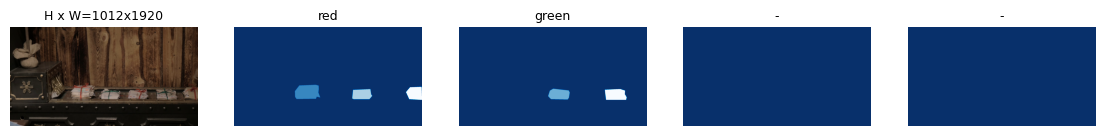

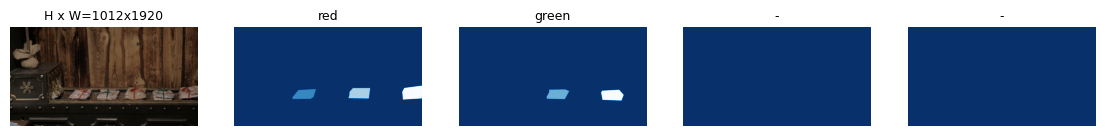

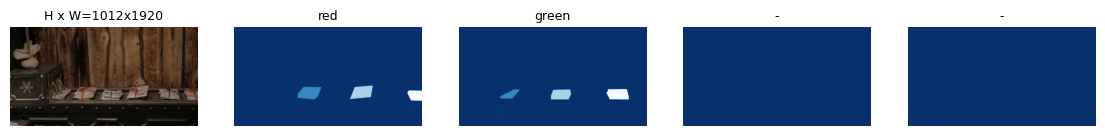

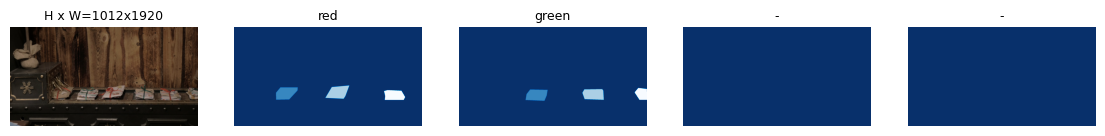

In [ ]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('dataset/train.json', 'dataset/train/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('dataset/val.json', 'dataset/val/')
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 4)

print('Train', len(dataset_train.image_ids))
print('Validation', len(dataset_val.image_ids))

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

<h2>Create the Training Model

In [ ]:
model = modellib.MaskRCNN(
    mode="training",
    config=config,
    model_dir=MODEL_DIR)

model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

[링크 텍스트](https://)<h2>Head Only

In [ ]:
start_train = time.time()

model.train(
    dataset_train,
    dataset_val, 
    learning_rate=config.LEARNING_RATE, 
    epochs=10, 
    layers='heads')


end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)



print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: Mask_RCNN/logs/cvproject20230530T1240/mask_rcnn_cvproject_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Tim

/Users/yunjongseo/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/yunjongseo/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classi

1/4 [======>.......................] - ETA: 1:40 - batch: 0.0000e+00 - size: 5.0000 - loss: 5.5116 - rpn_class_loss: 0.2074 - rpn_bbox_loss: 0.8781 - mrcnn_class_loss: 2.8623 - mrcnn_bbox_loss: 1.1151 - mrcnn_mask_loss: 0.4487

2023-05-30 12:41:08.962297: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-05-30 12:41:08.962326: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-05-30 12:41:34.495483: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-05-30 12:41:34.549763: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-05-30 12:41:34.593701: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Mask_RCNN/logs/cvproject20230530T1240/plugins/profile/2023_05_30_12_41_34
2023-05-30 12:41:34.613499: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to Mask_RCNN/logs/cvproject20230530T1240/plugins/profile/2023_05_30_12_41_34/yunjongseoui-MacBookAir.local.trace.json.gz
2023-05-30 12:41:34.680871: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: Mask_RC

4/4 [==============================] - ETA: 0s - batch: 1.5000 - size: 5.0000 - loss: 3.9656 - rpn_class_loss: 0.1414 - rpn_bbox_loss: 0.6566 - mrcnn_class_loss: 1.8008 - mrcnn_bbox_loss: 1.0113 - mrcnn_mask_loss: 0.3556    

/Users/yunjongseo/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4/4 [==============================] - 140s 35s/step - batch: 1.5000 - size: 5.0000 - loss: 3.9656 - rpn_class_loss: 0.1414 - rpn_bbox_loss: 0.6566 - mrcnn_class_loss: 1.8008 - mrcnn_bbox_loss: 1.0113 - mrcnn_mask_loss: 0.3556 - val_loss: 2.6161 - val_rpn_class_loss: 0.0674 - val_rpn_bbox_loss: 0.5097 - val_mrcnn_class_loss: 0.9947 - val_mrcnn_bbox_loss: 0.7033 - val_mrcnn_mask_loss: 0.3410
Epoch 2/10
4/4 [==============================] - 129s 34s/step - batch: 1.5000 - size: 5.0000 - loss: 2.1668 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.3327 - mrcnn_class_loss: 0.7655 - mrcnn_bbox_loss: 0.6324 - mrcnn_mask_loss: 0.3753 - val_loss: 1.5890 - val_rpn_class_loss: 0.0746 - val_rpn_bbox_loss: 0.4110 - val_mrcnn_class_loss: 0.3595 - val_mrcnn_bbox_loss: 0.4580 - val_mrcnn_mask_loss: 0.2859
Epoch 3/10
4/4 [==============================] - 123s 31s/step - batch: 1.5000 - size: 5.0000 - loss: 1.4945 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_lo

NameError: name 'hist' is not defined

<h2>Prepare to run Inference

In [ ]:
class InferenceConfig(TrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85

inference_config = InferenceConfig()

# Recreate the model in inference mode
test_model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

model_path = test_model.find_last()
print(model_path)

test_model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Mask_RCNN/logs/cvproject20230530T1240/mask_rcnn_cvproject_0010.h5
Re-starting from epoch 10


<h2>Run Inference

Processing 1 images
image                    shape: (1012, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  122.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


/Users/yunjongseo/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


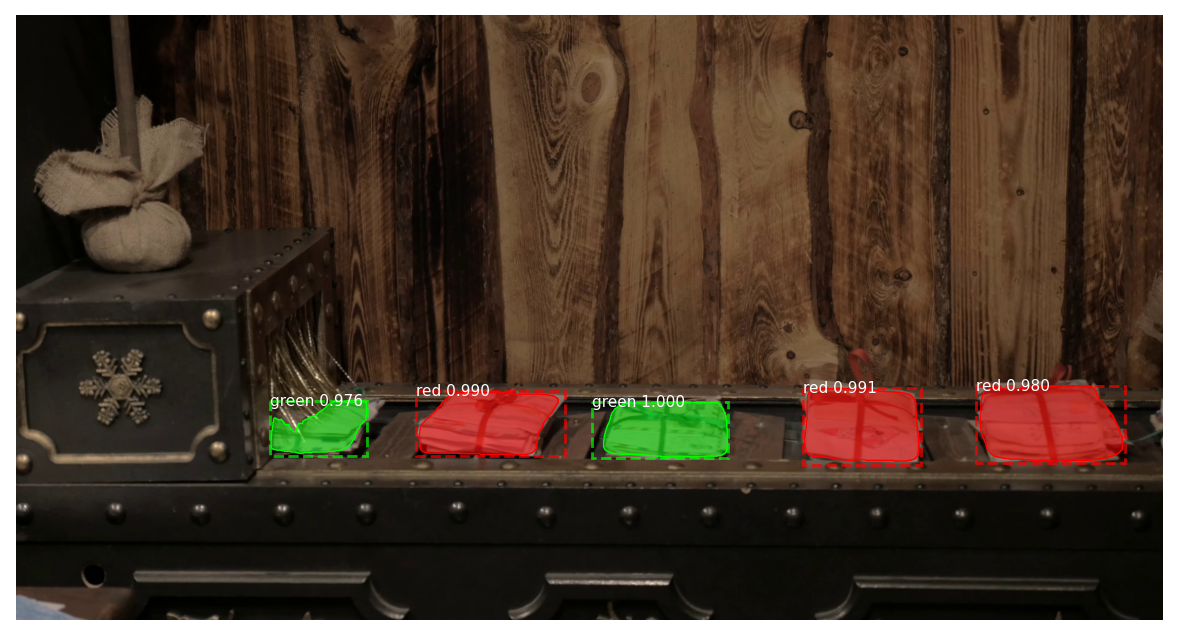

Processing 1 images
image                    shape: (1012, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  119.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


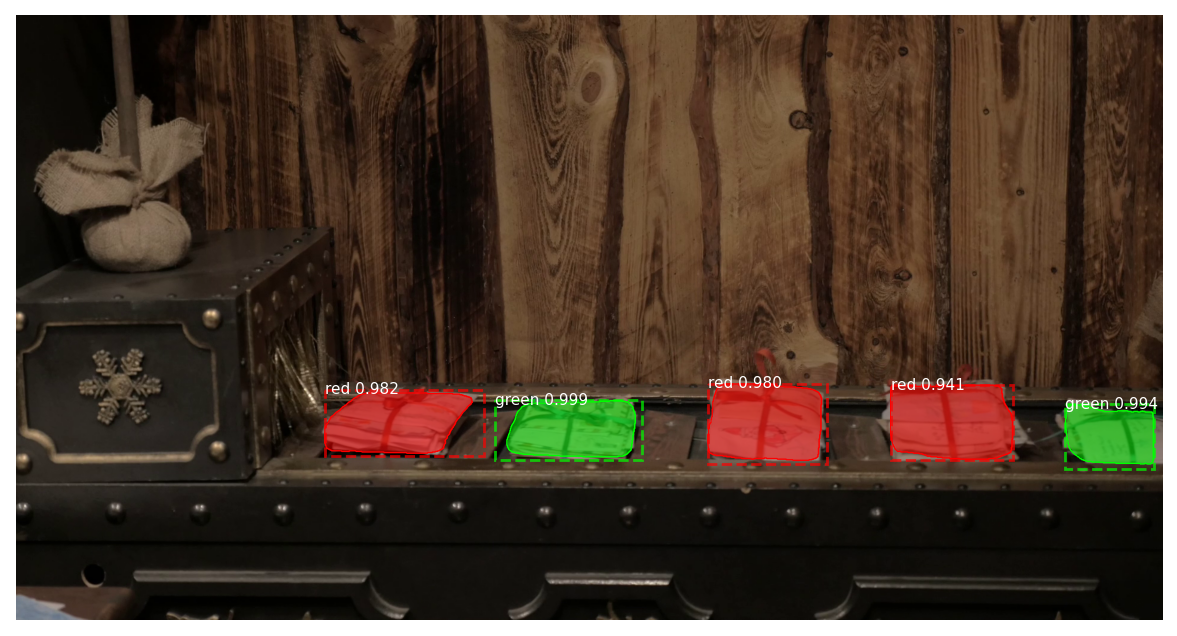

Processing 1 images
image                    shape: (1012, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  128.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


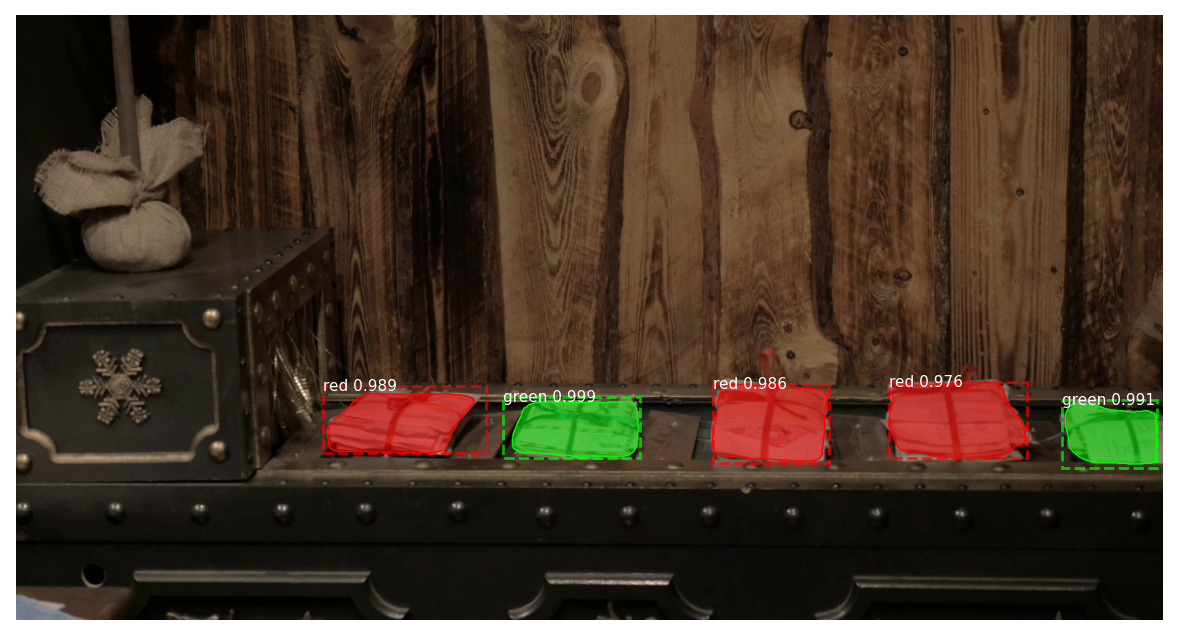

Processing 1 images
image                    shape: (1012, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  124.30000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


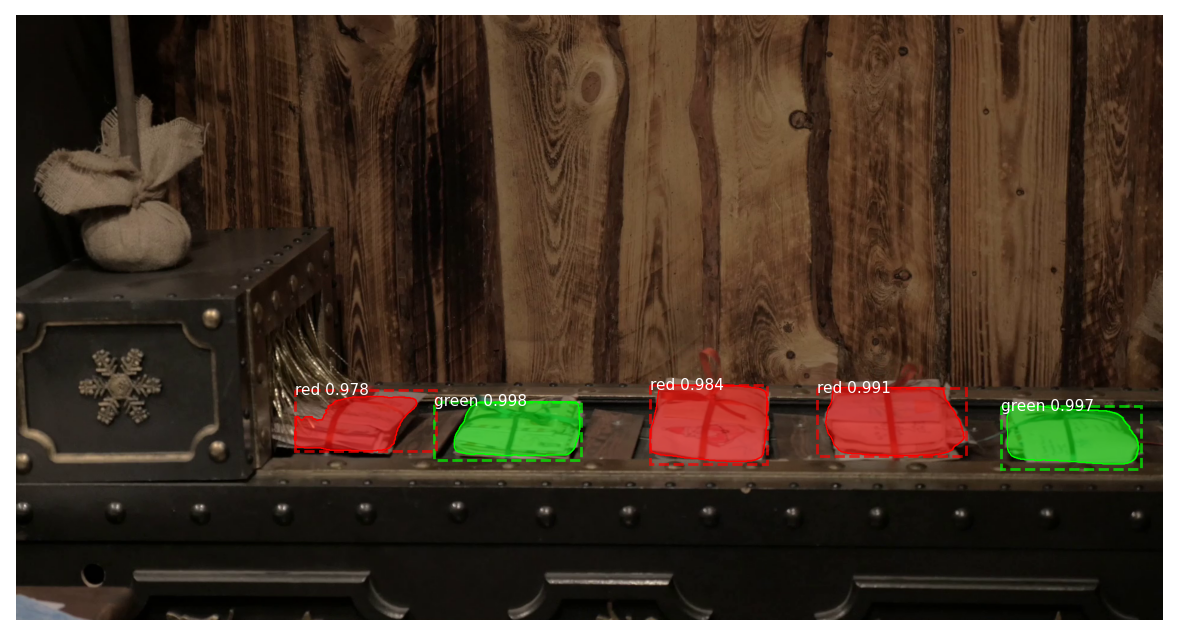

Processing 1 images
image                    shape: (1012, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  133.20000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


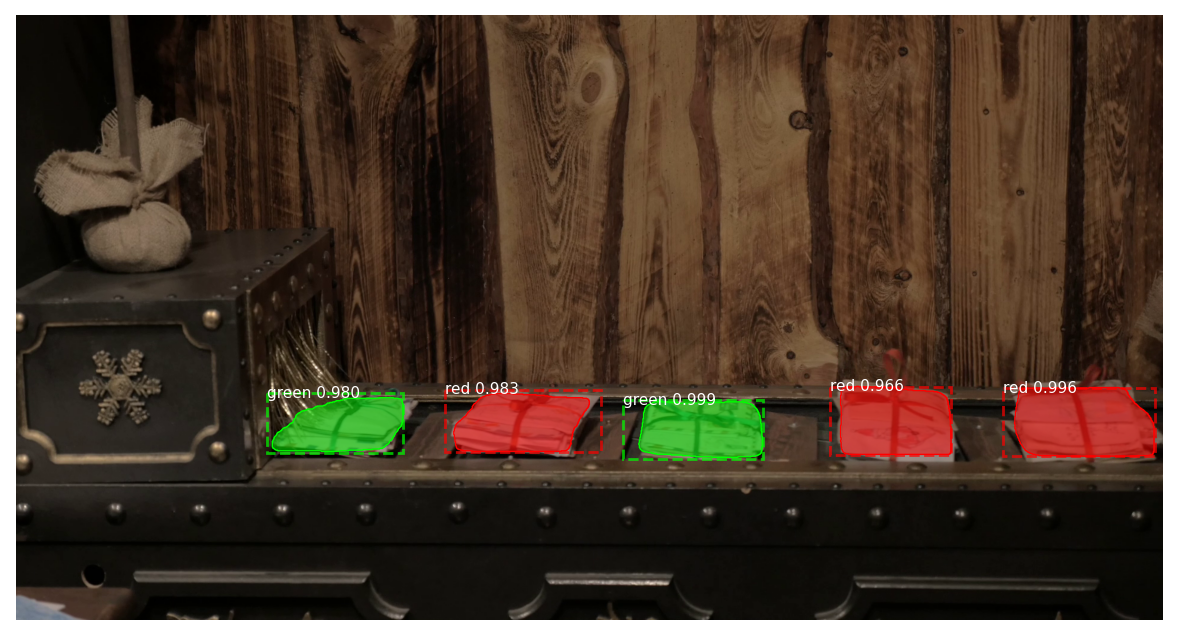

In [ ]:
import skimage

mask_colors = [
    (0., 0., 0.), # Background
    (1., 0., 0.), # Red
    (0., 1., 0.)  # Green
]

real_test_dir = 'dataset/val'
image_paths = []

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)

    results = test_model.detect([img_arr], verbose=1)
    r = results[0]

    colors = tuple(np.take(mask_colors, r['class_ids'], axis=0))

    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 8),
                                colors=colors)